In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime


# convert datetime string to integer (seconds since unix epoch)
def dt2int(dtstr, fmt="%Y-%m-%d %H:%M:%S"):
    return int(datetime.strptime(dtstr, fmt).strftime("%s"))


def visualize_meal(meal_time, meal_data, dt_min=None, dt_max=None, fmt="-"):
    plt.plot(meal_time, meal_data, fmt, color="orange")
    plt.xlabel("Epoch Time")
    plt.ylabel("Meal Size (g)")
    # plt.xlim(dt_min, dt_max)
    # plt.xticks(np.arange(dt_min, dt_max, 10000), rotation=90)


# visualize insulin data
def visualize_insulin(insulin_time, insulin_data, dt_min=None, dt_max=None, fmt="-"):
    plt.plot(insulin_time, insulin_data, fmt, color="green")
    plt.xlabel("Epoch Time")
    plt.ylabel("Insulin Delivered (mU)")
    # plt.xlim(dt_min, dt_max)
    # plt.xticks(np.arange(dt_min, dt_max, 10000), rotation=90)


# visualize cgm data
def visualize_cgm(cgm_time, cgm_data, dt_min=None, dt_max=None, fmt="-"):
    plt.plot(cgm_time, cgm_data, fmt, color="red")
    plt.xlabel("Epoch Time")
    plt.ylabel("BGL (mg/dL)")
    # plt.xlim(dt_min, dt_max)
    # plt.xticks(np.arange(dt_min, dt_max, 10000), rotation=90)


# visualize all data
def visualize(cgm_data, meal_data, insulin_data, dt_min=None, dt_max=None, fmt="-"):
    plt.figure(figsize=(8, 10))

    plt.subplot(311)
    visualize_meal(*meal_data, dt_min, dt_max, fmt)

    plt.subplot(312)
    visualize_insulin(*insulin_data, dt_min, dt_max, fmt)

    plt.subplot(313)
    visualize_cgm(*cgm_data, dt_min, dt_max, fmt)

    plt.tight_layout()
    plt.show()


In [5]:
import numpy as np
import pandas as pd


# utility function to interpolate data
def interpolate(cgm_data, meal_data, insulin_data, resolution=1 * 60):
    # interpolate data for fitting
    t_min = min(
        (
            meal_data.LocalDtTm.min(),
            insulin_data.LocalDeliveredDtTm.min(),
            cgm_data.LocalDtTm.min(),
        )
    )
    t_max = max(
        (
            meal_data.LocalDtTm.max(),
            insulin_data.LocalDeliveredDtTm.max(),
            cgm_data.LocalDtTm.max(),
        )
    )
    # resolution = 1 * 60   # 1 min

    t_interp = np.arange(t_min, t_max, resolution)

    meal_interp = np.zeros_like(t_interp)
    for _, row in meal_data.iterrows():
        meal_interp[int((row.LocalDtTm - t_interp[0]) // 60)] = row.MealSize

    insulin_interp = np.zeros_like(t_interp)
    for _, row in insulin_data.iterrows():
        insulin_interp[
            int((row.LocalDeliveredDtTm - t_interp[0]) // 60)
        ] = row.DeliveredValue

    cgm_interp = np.interp(t_interp, cgm_data["LocalDtTm"], cgm_data["CGM"])

    return t_interp, cgm_interp, meal_interp, insulin_interp


# C3R data class
class C3RData:
    def __init__(
        self,
        data_dir,
        cgm_data="MonitorCGM.txt",
        meal_data="MonitorMeal.txt",
        insulin_data="MonitorTotalBolus.txt",
    ):
        self.data_dir = data_dir
        self.cgm_data = pd.read_csv(f"{data_dir}/{cgm_data}", sep="|")
        self.meal_data = pd.read_csv(f"{data_dir}/{meal_data}", sep="|")
        self.insulin_data = pd.read_csv(f"{data_dir}/{insulin_data}", sep="|")

    def get_case_df(self, df, deident_id, from_dt, to_dt, dtcol="LocalDtTm"):
        df_case = df.copy()
        df_case = df_case.loc[df_case.DeidentID == deident_id]
        df_case[dtcol] = df_case[dtcol].map(dt2int)
        df_case = df_case.sort_values(by=[dtcol]).reset_index()
        df_case = df_case.loc[(df_case[dtcol] >= from_dt) & (df_case[dtcol] < to_dt)]

        return df_case

    def get_dates(self, deident_id):
        cgm_df = self.cgm_data
        cgm_dates = (
            cgm_df["LocalDtTm"]
            .map(lambda dt: dt[:10])
            .loc[cgm_df["DeidentID"] == deident_id]
            .sort_values()
            .unique()
        )

        return cgm_dates

    # get data of a given case
    def get_case(self, deident_id, from_dt, to_dt):
        from_dt = dt2int(from_dt)
        to_dt = dt2int(to_dt)

        cgm = self.get_case_df(self.cgm_data, deident_id, from_dt, to_dt)
        meal = self.get_case_df(self.meal_data, deident_id, from_dt, to_dt)
        insulin = self.get_case_df(
            self.insulin_data,
            deident_id,
            from_dt,
            to_dt,
            "LocalDeliveredDtTm",
        )

        return cgm, meal, insulin

In [6]:
!pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 7.2 MB/s eta 0:00:00


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

import sys
sys.path.append('/content/PINN-CGM-1/simglucose')

from collections import namedtuple
from simglucose.patient.t1dpatient import T1DPatient

from simglucose.sensor.cgm import CGMSensor
from simglucose.simulation.env import T1DSimEnv
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.sim_engine import SimObj, sim
from simglucose.simulation.scenario import CustomScenario
from simglucose.controller.basal_bolus_ctrller import BBController

from tqdm.notebook import tqdm, trange
from deap import base, creator, tools, cma

You could install pathos to enable parallel simulation.


In [8]:
# config
GLOBAL_SEED = 0
RESULTS_PATH = "results/"

# better plots
sns.set()

# tqdm
tqdm.pandas()

In [9]:
# load dataset
c3r = C3RData(data_dir="/content/PINN-CGM-1/data")

# get data for a certain case
deident_id = 2
from_dt = f"2014-05-05 00:00:00"
to_dt = f"2014-05-06 00:00:00"


# destructure data
cgm_data, meal_data, insulin_data = c3r.get_case(deident_id, from_dt, to_dt)
data_t, data_CGM, data_CHO, data_insulin = interpolate(cgm_data, meal_data, insulin_data)

# normalize time
data_t -= data_t[0]

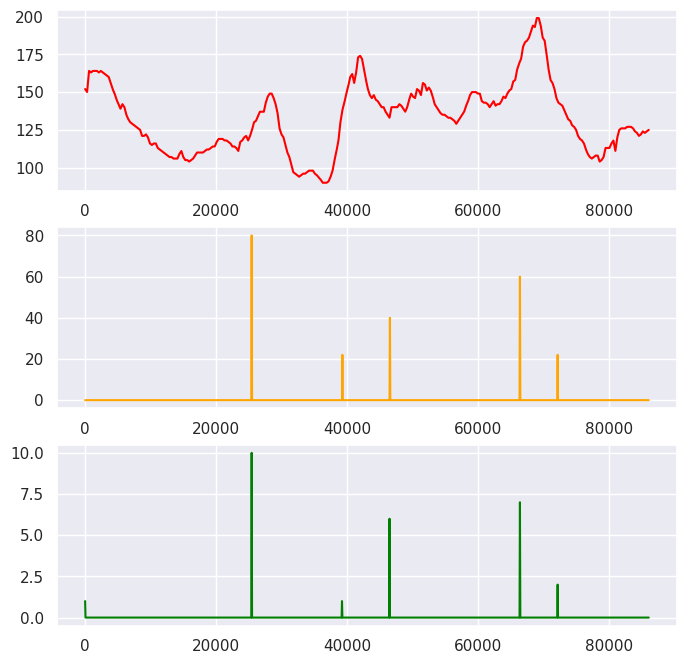

In [10]:
# visualize data
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(data_t, data_CGM, label="CGM", color="red")
plt.subplot(3, 1, 2)
plt.plot(data_t, data_CHO, label="CHO", color="orange")
plt.subplot(3, 1, 3)
plt.plot(data_t, data_insulin, label="insulin", color="green")
plt.show()

In [11]:
!pip install torchdiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from torchdiffeq import odeint
from collections import namedtuple
from tqdm.notebook import tqdm, trange

In [13]:
# better plots
sns.set_style('whitegrid')

# better progress
tqdm.pandas()

# use GPU
device = torch.device("cpu")
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("CUDA available. Setting all tensors on GPU by default.")
#     torch.set_default_tensor_type(torch.cuda.FloatTensor)

# batch size
batch_size = 32

In [ ]:
# read data
data = pd.read_csv("/content/PINN-CGM-1/results/adult#001.csv")

# destructure data
data_t = data["Time"].map(lambda d: dt2int(d, fmt="%Y-%m-%d %H:%M:%S.%f")).to_numpy()
data_BG = data["BG"].to_numpy()
data_CGM = data["CGM"].to_numpy()
data_CHO = data["CHO"].to_numpy()
data_insulin = data["insulin"].to_numpy()

# normalize time
data_t -= data_t[0]

# scale down to minutes
data_t = data_t / 60.0

# clean
data_CHO = np.nan_to_num(data_CHO, nan=data_CHO[0])
data_insulin = np.nan_to_num(data_insulin, nan=data_insulin[0])

In [ ]:
data

,Time,BG,CGM,CHO,insulin,LBGI,HBGI,Risk
0,2023-04-24 02:59:11.789500,138.560000,161.673198,0.0,0.021125,0.000000,1.510902,1.510902
1,2023-04-24 03:02:11.789500,138.560000,160.359506,0.0,0.021125,0.000000,1.510902,1.510902
2,2023-04-24 03:05:11.789500,138.560000,159.285499,0.0,0.021125,0.000000,1.510902,1.510902
3,2023-04-24 03:08:11.789500,138.560000,158.295766,0.0,0.021125,0.000000,1.510902,1.510902
4,2023-04-24 03:11:11.789500,138.560000,157.552340,0.0,0.021125,0.000000,1.510902,1.510902
...,...,...,...,...,...,...,...,...
476,2023-04-25 02:47:11.789500,106.113865,118.143612,0.0,0.021125,0.119117,0.000000,0.119117
477,2023-04-25 02:50:11.789500,105.445625,115.975283,0.0,0.021125,0.146170,0.000000,0.146170
478,2023-04-25 02:53:11.789500,104.744227,114.819748,0.0,0.021125,0.177751,0.000000,0.177751
479,2023-04-25 02:56:11.789500,104.012598,115.268450,0.0,0.021125,0.214237,0.000000,0.214237


In [14]:
tensor_t = torch.tensor(data_t, dtype=torch.float32, device=device).reshape(-1, 1)
tensor_CGM = torch.tensor(data_CGM, dtype=torch.float32, device=device).reshape(-1, 1)

In [15]:
tensor_CGM

tensor([[152.0000],
        [151.5987],
        [151.1973],
        ...,
        [124.6100],
        [124.8100],
        [125.0000]])

In [16]:
# in_time = torch.from_numpy(data_t).float().to(device)
# in_CHO = torch.from_numpy(data_CHO).float().to(device)
# in_insulin = torch.from_numpy(data_insulin).float().to(device)
# in_CGM = torch.from_numpy(data_CGM).float().to(device)

dataset = TensorDataset(tensor_t, tensor_CGM)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))

In [17]:
dataset

In [18]:
# load parameters
orig_params = pd.read_csv("/content/PINN-CGM-1/parameters/vpatient_params.csv")
mean_params = orig_params.loc[orig_params["Name"] == "adult#001"].squeeze()
mean_params = mean_params.rename(lambda x: x.replace(" ", ""))
adult_params = orig_params[orig_params.Name.str.contains("adult")]

min_params = adult_params.min()
max_params = adult_params.max()

def get_param(p, p_min, p_max):
    return ((torch.tanh(p) + 1) / 2) * (p_max - p_min) + p_min

In [19]:
orig_params

,Name,i,x0_ 1,x0_ 2,x0_ 3,x0_ 4,x0_ 5,x0_ 6,x0_ 7,x0_ 8,...,kd,ksc,ka1,ka2,dosekempt,u2ss,isc1ss,isc2ss,kp1,patient_history
0,adolescent#001,1,0.0,0.0,0.0,250.621836,176.506560,4.697518,0.0,97.554000,...,0.01850,0.05600,0.00250,0.01150,90000.0,1.216976,57.951224,93.225883,11.504823,0
1,adolescent#002,2,0.0,0.0,0.0,280.236267,30.954131,6.019305,0.0,119.180000,...,0.01630,0.13140,0.00680,0.02690,90000.0,1.798300,77.848476,47.172125,4.196579,0
2,adolescent#003,3,0.0,0.0,0.0,326.553380,383.368339,3.487881,0.0,101.280000,...,0.01490,0.10590,0.00300,0.01480,90000.0,1.446266,80.796984,81.342909,6.588789,0
3,adolescent#004,4,0.0,0.0,0.0,248.117090,214.758608,4.316765,0.0,108.880000,...,0.01550,0.07510,0.00260,0.01210,90000.0,1.762633,97.383030,124.746857,6.041685,0
4,adolescent#005,5,0.0,0.0,0.0,279.047113,144.715759,5.162898,0.0,113.090000,...,0.01510,0.08660,0.00320,0.01770,90000.0,1.534645,83.860398,71.541921,4.642232,0
5,adolescent#006,6,0.0,0.0,0.0,257.421705,162.558571,8.154419,0.0,113.000000,...,0.01800,0.07370,0.00610,0.02730,90000.0,1.927878,79.994952,52.743925,7.665231,0
6,adolescent#007,7,0.0,0.0,0.0,238.918844,87.961590,5.234234,0.0,111.900000,...,0.01760,0.05030,0.00410,0.01880,90000.0,2.049148,94.430770,88.403274,6.422606,0
7,adolescent#008,8,0.0,0.0,0.0,263.838120,33.927415,4.730161,0.0,82.914000,...,0.01740,0.08040,0.00350,0.01490,90000.0,1.353241,64.748395,75.612219,4.325662,0
8,adolescent#009,9,0.0,0.0,0.0,241.447500,184.846173,4.707833,0.0,84.982000,...,0.01670,0.09120,0.00270,0.01130,90000.0,1.381865,71.230166,105.269360,9.971336,0
9,adolescent#010,10,0.0,0.0,0.0,267.183741,169.711073,6.321865,0.0,108.240000,...,0.01440,0.10450,0.00340,0.01730,90000.0,1.661090,93.319683,77.676499,5.084551,0


In [20]:
# system parameters
_kp2  = torch.tensor(mean_params["kp2"]) 
_k1   = torch.tensor(mean_params["k1"])
_k2   = torch.tensor(mean_params["k2"])
_kp1  = torch.tensor(mean_params["kp1"])
_ki   = torch.tensor(mean_params["ki"])
_ke1  = torch.tensor(mean_params["ke1"])
_kmax = torch.tensor(mean_params["kmax"])
_kmin = torch.tensor(mean_params["kmin"])
_kabs = torch.tensor(mean_params["kabs"])
_kp3  = torch.tensor(mean_params["kp3"])
_params = torch.tensor([_kp2, _k1, _k2, _kp1, _ki, _ke1, _kmax, _kmin, _kabs, _kp3])

In [21]:
# required data structures
Action = namedtuple("patient_action", ['CHO', 'insulin'])

In [22]:
in_time = torch.tensor(data_t)
in_CHO = torch.tensor(data_CHO)
in_insulin = torch.tensor(data_insulin)

def ode(t, x):
    # instantiate derivatives
    dxdt = torch.zeros(13)

    # parameters
    params = mean_params
    kabs = get_param(_kabs, min_params["kabs"], max_params["kabs"])
    kmax = get_param(_kmax, min_params["kmax"], max_params["kmax"])
    kmin = get_param(_kmin, min_params["kmin"], max_params["kmin"])
    k2 = get_param(_k2, min_params["k2"], max_params["k2"])
    k1 = get_param(_k1, min_params["k1"], max_params["k1"])
    ki = get_param(_ki, min_params["ki"], max_params["ki"])
    kp2 = get_param(_kp2, min_params["kp2"], max_params["kp2"])
    kp3 = get_param(_kp3, min_params["kp3"], max_params["kp3"])
    ke1 = get_param(_ke1, min_params["ke1"], max_params["ke1"])
    kp1 = get_param(_kp1, min_params["kp1"], max_params["kp1"])

    # get current action
    t_mask = torch.abs(in_time - t).argmin()
    action = Action(CHO=in_CHO[t_mask], insulin=in_insulin[t_mask])

    d = action.CHO * 1000 # g -> mg
    insulin = action.insulin * 6000 / params.BW

    # glucose in the stomach
    qsto = x[0] + x[1]

    last_foodtaken = 0
    if t_mask > 0:
        last_foodtaken = in_CHO[t_mask - 1]
    
    Dbar = last_foodtaken * 1000 # unit: mg

    # stomach solid
    dxdt[0] = -kmax * x[0] + d

    if Dbar > 0:
        aa = 5 / 2 / (1 - params.b) / Dbar
        cc = 5 / 2 / params.d / Dbar
        kgut = kmin + (kmax - kmin) / 2 * (
            torch.tanh(aa * (qsto - params.b * Dbar))
            - torch.tanh(cc * (qsto - params.d * Dbar))
            + 2
        )
    else:
        kgut = kmax

    # stomach liquid
    dxdt[1] = kmax * x[0] - x[1] * kgut

    # intestine
    dxdt[2] = kgut * x[1] - kabs * x[2]

    # Rate of appearance
    Rat = params.f * kabs * x[2] / params.BW
    # Glucose Production
    EGPt = kp1 - kp2 * x[3] - kp3 * x[8]
    # Glucose Utilization
    Uiit = params.Fsnc

    # renal excretion
    if x[3] > params.ke2:
        Et = ke1 * (x[3] - params.ke2)
    else:
        Et = 0

    # glucose kinetics
    # plus dextrose IV injection input u[2] if needed
    dxdt[3] = max(EGPt, 0) + Rat - Uiit - Et - k1 * x[3] + k2 * x[4]
    dxdt[3] = (x[3] >= 0) * dxdt[3]

    Vmt = params.Vm0 + params.Vmx * x[6]
    Kmt = params.Km0
    Uidt = Vmt * x[4] / (Kmt + x[4])
    dxdt[4] = -Uidt + k1 * x[3] - k2 * x[4]
    dxdt[4] = (x[4] >= 0) * dxdt[4]

    # insulin kinetics
    dxdt[5] = (
        -(params.m2 + params.m4) * x[5]
        + params.m1 * x[9]
        + params.ka1 * x[10]
        + params.ka2 * x[11]
    )  # plus insulin IV injection u[3] if needed
    It = x[5] / params.Vi
    dxdt[5] = (x[5] >= 0) * dxdt[5]

    # insulin action on glucose utilization
    dxdt[6] = -params.p2u * x[6] + params.p2u * (It - params.Ib)

    # insulin action on production
    dxdt[7] = -ki * (x[7] - It)

    dxdt[8] = -ki * (x[8] - x[7])

    # insulin in the liver (pmol/kg)
    dxdt[9] = -(params.m1 + params.m30) * x[9] + params.m2 * x[5]
    dxdt[9] = (x[9] >= 0) * dxdt[9]

    # subcutaneous insulin kinetics
    dxdt[10] = insulin - (params.ka1 + params.kd) * x[10]
    dxdt[10] = (x[10] >= 0) * dxdt[10]

    dxdt[11] = params.kd * x[10] - params.ka2 * x[11]
    dxdt[11] = (x[11] >= 0) * dxdt[11]

    # subcutaneous glucose
    dxdt[12] = -params.ksc * x[12] + params.ksc * x[3]
    dxdt[12] = (x[12] >= 0) * dxdt[12]

    return dxdt


In [23]:
# initial conditions
f_0 = torch.tensor(mean_params.iloc[2:15], dtype=torch.float32)

In [24]:
# timespan
tspan = (data_t[0], data_t[-1])

In [25]:
def output_transform(t, u, u_0):
    u1 = u.unfold(0, window_size, 1).transpose(1, 2)
    t_t_reshaped = t_t.unsqueeze(1).expand(-1, u1.shape[1], -1)
    return u1 * torch.tanh(t_t_reshaped) + u_0


In [26]:
# loss criterion
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

# loss criterion
class MSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return self.mse(torch.log(pred + 1), torch.log(actual + 1))

In [73]:
# generate features
window_size = 5
t1 = []
if device.type == 'cuda':
    t = torch.cuda.FloatTensor(100, 1).uniform_(*tspan)
else:
    t = torch.FloatTensor(100, 1).uniform_(*tspan)
t.requires_grad_(True)
# for i in range(window_size, len(t)):
#     t1.append(t[i-window_size:i])
t_t = t.unfold(0, window_size, 1)
t_t = t_t.reshape(96,-1)
t_t.shape
# ODE loss
def ode_loss(model, ode, criterion, f_0):
    # get preds
    NN_t = model(t_t)
    # print(NN_t.shape)
    # NN_t = NN_t.reshape(96, 5)
    NN_t = output_transform(t_t, NN_t, f_0)
    # print(NN_t.shape)

    dNN_dt = torch.hstack([
        autograd.grad(
            NN_t[:, i:i+1],
            t_t,
            grad_outputs=torch.ones_like(t_t),
            create_graph=True,
            retain_graph=True,
        )[0]
        for i in range(5)
    ])
    df_dt = torch.vstack([ode(t_i, x_i) for (t_i, x_i) in zip(t, NN_t)])

    loss = criterion(dNN_dt, df_dt.view(1, -1))

    return loss

In [74]:
t_t.shape


torch.Size([96, 5])

In [ ]:
a = ode_loss(model, ode, criterion, f_0)

In [76]:
# train model for given number of epochs
def train(model, opt, criterion, loader, epochs, informed=False, logfreq=100):
    # train model
    loss_history = []
    for epoch in (pbar := trange(epochs)):
        loss_batch = 0
        for i, data in enumerate(loader):
            opt.zero_grad()

            features, targets = data

            preds = model(features)[:, 12:13] / mean_params.Vg
            loss = criterion(preds, targets)

            # ode loss
            if informed:
                loss += ode_loss(model, ode, criterion, f_0)

            loss.backward()
            opt.step()

            loss_batch += loss.item()
        loss_batch = loss_batch / len(loader)

        if epoch % logfreq == 0 or epoch == epochs - 1:
            pbar.set_postfix(loss=f"{loss_batch:.2e}")
            loss_history.append(loss_batch)

    return loss_history

In [30]:
# network
model = nn.Sequential(
    nn.Linear(1, 64),
    nn.SiLU(),
    nn.Linear(64, 64),
    nn.SiLU(),
    nn.Linear(64, 64),
    nn.SiLU(),
    nn.Linear(64, 64),
    nn.SiLU(),
    nn.Linear(64, 64),
    nn.SiLU(),
    nn.Linear(64, 64),
    nn.SiLU(),
    nn.Linear(64, 64),
    nn.SiLU(),
    nn.Linear(64, 13),
)

# optimizer
opt = optim.Adam(model.parameters(), lr=0.001)

# loss
criterion = nn.MSELoss()

In [32]:
# train network
epochs = 100
loss_history = train(model, opt, criterion, loader, epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
plt.plot(loss_history, "r")
plt.show()

In [ ]:
with torch.no_grad():
    plt.plot(data_t, data_CGM, "r")
    plt.plot(data_t, model(tensor_t).cpu()[:, 12:13] / mean_params.Vg, "b")
    plt.show()

In [ ]:
# train network (informed loss)
epochs = 1000
loss_history = train(model, opt, criterion, loader, epochs, informed=True)

In [ ]:
plt.plot(loss_history, "r")
plt.show()

In [ ]:
with torch.no_grad():
    plt.plot(data_t, data_CGM, "r")
    plt.plot(data_t, model(tensor_t).cpu()[:, 12:13] / mean_params.Vg, "b")
    plt.show()

Window-based optimization

In [57]:
# window size
window_size = 10

# create sliding window dataset
inputs = []
targets = []
for i in range(window_size, len(data_CGM)):
    inputs.append(data_CGM[i-window_size:i])
    targets.append(data_CGM[i])
inputs = np.array(inputs)
targets = np.array(targets)
inputs1 = inputs
targets1 = targets
# convert to PyTorch tensors
tensor_inputs = torch.tensor(inputs, dtype=torch.float32, device=device)
tensor_targets = torch.tensor(targets, dtype=torch.float32, device=device)

dataset = TensorDataset(tensor_inputs, tensor_targets)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))


In [58]:
data_CGM.shape

(1436,)

In [ ]:

# define MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# model parameters
input_size = window_size
hidden_size = 32
output_size = 1

# create MLP model
model = MLP(input_size, hidden_size, output_size).to(device)

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []
# train the model
epochs = 100
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(loader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        # loss += ode_loss(model, ode, criterion, f_0)
        loss = nn.MSELoss()(outputs, targets)
        loss.backward()
      
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss)
    # Print training progress
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")



In [66]:
outputs.shape

torch.Size([18, 1])

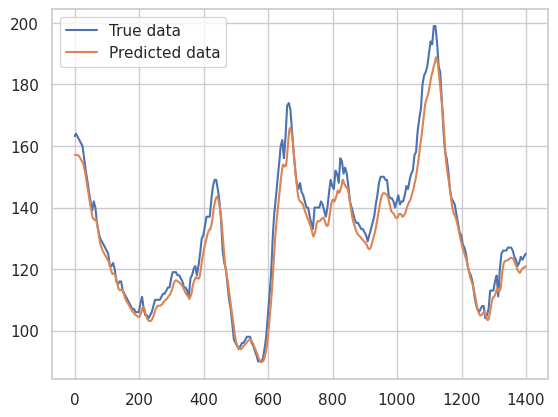

In [67]:
# set the model to evaluation mode
model.eval()

# make predictions on the test set
with torch.no_grad():
    test_inputs = tensor_inputs[-1400:] # use the last 100 samples as the test set
    test_targets = tensor_targets[-1400:]
    test_outputs = model(test_inputs)

# plot the predicted data and the true data
plt.plot(test_targets.cpu().numpy(), color = 'blue', label='True data')
plt.plot(test_outputs.cpu().numpy(), color = 'blue',label='Predicted data')
plt.legend()
plt.show()


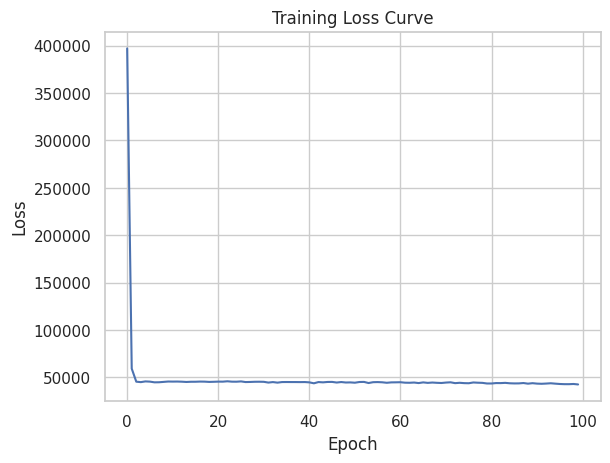

In [68]:
# plot loss curve
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

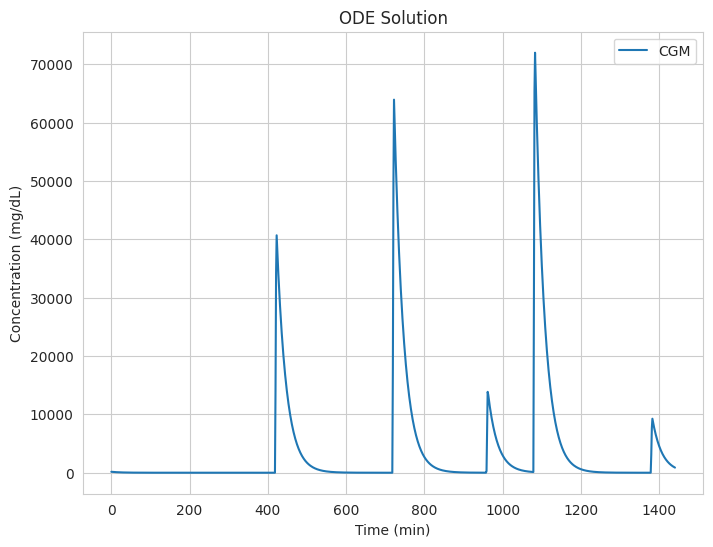

In [ ]:
def plot_ode_solution(params):
    # define the initial conditions
    x0 = torch.zeros(13)
    x0[0] = data_CGM[0]
    x0[1] = 1.0 # arbitrary value
    x0[2] = 0.0 # arbitrary value
    x0[3] = 0.0 # arbitrary value
    x0[4] = 0.0 # arbitrary value
    x0[5] = 0.0 # arbitrary value
    x0[6] = 0.0 # arbitrary value
    x0[7] = 0.0 # arbitrary value
    x0[8] = 0.0 # arbitrary value
    x0[9] = 0.0 # arbitrary value
    x0[10] = 0.0 # arbitrary value
    x0[11] = 0.0 # arbitrary value
    x0[12] = 0.0 # arbitrary value
    
    # system parameters
    _kp2 = torch.tensor(params["kp2"])
    _k1 = torch.tensor(params["k1"])
    _k2 = torch.tensor(params["k2"])
    _kp1 = torch.tensor(params["kp1"])
    _ki = torch.tensor(params["ki"])
    _ke1 = torch.tensor(params["ke1"])
    _kmax = torch.tensor(params["kmax"])
    _kmin = torch.tensor(params["kmin"])
    _kabs = torch.tensor(params["kabs"])
    _kp3 = torch.tensor(params["kp3"])
    _params = torch.tensor([_kp2, _k1, _k2, _kp1, _ki, _ke1, _kmax, _kmin, _kabs, _kp3])

    # solve the ODE using odeint
    t_eval = torch.linspace(0, data_t[-1], 1000)
    with torch.no_grad():
        x = odeint(ode, x0, t_eval, method='dopri5', rtol=1e-4, atol=1e-6, args=(_params,))

    # plot the solution
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(t_eval.numpy(), x[:, 0].numpy(), label='CGM')
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Concentration (mg/dL)')
    ax.set_title('ODE Solution')
    ax.legend()
    plt.show()
plot_ode_solution(mean_params)
